In [1]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
sys.path.append(pyAPES_main_folder)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

from pyAPES_utilities.timeseries_tools import diurnal_cycle

sns.set_context('paper', font_scale=1.5)
%matplotlib widget

In [2]:
# Load simulation data
simdata = xr.open_dataset('../../results/FiHy2018_lad.nc')

# Define LAI values and corresponding simulation indices
# LAI_total = np.linspace(0.5, 5, 10) from hyytiala_2018_lad.py
# LAI 1.0 m²/m² -> simulation 1
# LAI 3.0 m²/m² -> simulation 5
# LAI 5.0 m²/m² -> simulation 9
LAI_values = [1.0, 3.0, 5.0]
sim_indices = [1, 5, 9]
colors_lai = ['tab:blue', 'tab:orange', 'tab:green']

# Planttype indices in simdata: 0=decid, 1=pine, 2=shrubs, 3=spruce
# We use decid, pine, spruce (exclude shrubs)
planttype_indices = [0, 1, 3]  # decid, pine, spruce

# LAI ratios from hyytiala_2018_lad.py (decid, pine, spruce only)
LAI_original = np.array([1.2, 2.1, 1.2])  # decid, pine, spruce
LAI_ratio = LAI_original / LAI_original.sum()

# Use all available data
simdata_period = simdata.sel(date=slice('2018-06-01','2018-06-30'))

In [3]:
# Calculate ecosystem-level variables for each LAI simulation
# NEE from canopy_NEE
# ET = canopy_transpiration + canopy_evaporation + ffloor_evaporation (mmol m-2 s-1)

MOLAR_MASS_H2O = 18.015  # g/mol

nee_data = {}
et_data = {}
evap_canopy_data = {}
evap_ffloor_data = {}
transp_data = {}

for lai, sim_idx in zip(LAI_values, sim_indices):
    nee = simdata_period['canopy_NEE'].isel(simulation=sim_idx)
    nee_data[lai] = nee
    
    # ET components (convert to mmol m-2 s-1)
    transp = simdata_period['canopy_transpiration'].isel(simulation=sim_idx) * 1000  # m/s -> kg/m2/s
    evap_canopy = simdata_period['canopy_evaporation'].isel(simulation=sim_idx)
    evap_ffloor = simdata_period['ffloor_evaporation'].isel(simulation=sim_idx)
    
    # Total ET in mmol m-2 s-1
    et_total = (transp + evap_canopy + evap_ffloor) / (MOLAR_MASS_H2O * 1e-3) * 1000
    et_data[lai] = et_total
    
    # Individual components in mmol m-2 s-1
    evap_canopy_data[lai] = evap_canopy / (MOLAR_MASS_H2O * 1e-3) * 1000
    evap_ffloor_data[lai] = evap_ffloor / (MOLAR_MASS_H2O * 1e-3) * 1000
    transp_data[lai] = transp / (MOLAR_MASS_H2O * 1e-3) * 1000

# Precipitation daily sum (same for all simulations)
prec_daily = simdata_period['forcing_precipitation'].isel(simulation=0).resample(date='1D').sum() / (MOLAR_MASS_H2O * 1e-3) # kg m-2 s-1 -> mol m-2 s-1

In [4]:
# Calculate vertical profile variables
# Select daytime data (10-14h)
hour_start = 10
hour_end = 14

time_mask = ((simdata.date.dt.hour >= hour_start) & (simdata.date.dt.hour <= hour_end))

simdata_profile = simdata.sel(date=time_mask)
canopy_z = simdata_profile['canopy_z'].values

# Store profile data for each LAI
profile_data = {}

for lai, sim_idx in zip(LAI_values, sim_indices):
    data_sim = simdata_profile.isel(simulation=sim_idx).mean(dim='date')
    
    # 1. Canopy sunlit fraction and downwelling PAR
    sunlit_frac = data_sim['canopy_sunlit_fraction'].values

    # Downwelling PAR at each canopy level
    par_down = data_sim['canopy_par_down'].values
    
    # 2. Leaf temperature - average across planttypes
    temp_sunlit = data_sim['pt_leaf_temperature_sunlit'].isel(planttype=planttype_indices).values
    temp_shaded = data_sim['pt_leaf_temperature_shaded'].isel(planttype=planttype_indices).values
    
    # Average sunlit/shaded by sunlit fraction, then average across planttypes
    temp_avg = np.zeros(len(canopy_z))
    for i, pt_idx in enumerate(planttype_indices):
        temp_pt = sunlit_frac * temp_sunlit[i, :] + (1 - sunlit_frac) * temp_shaded[i, :]
        temp_avg += temp_pt
    temp_avg /= len(planttype_indices)
    
    # 3. iWUE = Net CO2 / gs_h2o (weighted by net_co2 for sunlit/shaded and across planttypes)
    iwue_list = []
    net_co2_total_list = []
    
    for i, pt_idx in enumerate(planttype_indices):
        net_co2_sunlit = data_sim['pt_net_co2_sunlit'].isel(planttype=pt_idx).values
        net_co2_shaded = data_sim['pt_net_co2_shaded'].isel(planttype=pt_idx).values
        gs_sunlit = data_sim['pt_stomatal_conductance_h2o_sunlit'].isel(planttype=pt_idx).values
        gs_shaded = data_sim['pt_stomatal_conductance_h2o_shaded'].isel(planttype=pt_idx).values
        
        iwue_sunlit = np.where(gs_sunlit > 0, net_co2_sunlit / gs_sunlit, np.nan)
        iwue_shaded = np.where(gs_shaded > 0, net_co2_shaded / gs_shaded, np.nan)
        
        # Weight by net CO2 flux for sunlit/shaded combination
        net_co2_total = net_co2_sunlit + net_co2_shaded
        iwue_pt = (iwue_sunlit * net_co2_sunlit + iwue_shaded * net_co2_shaded) / net_co2_total
        
        iwue_list.append(iwue_pt)
        net_co2_total_list.append(net_co2_total)
    
    # Weighted average iWUE across planttypes by net_co2
    iwue_array = np.array(iwue_list)
    net_co2_array = np.array(net_co2_total_list)
    
    # Replace nan in iwue with 0 for weighted sum, track valid weights
    iwue_masked = np.where(np.isnan(iwue_array), 0, iwue_array)
    weights_masked = np.where(np.isnan(iwue_array), 0, net_co2_array)
    
    weight_sum = np.sum(weights_masked, axis=0)
    iwue_avg = np.where(weight_sum != 0, 
                        np.sum(iwue_masked * weights_masked, axis=0) / weight_sum, 
                        np.nan)
    
    profile_data[lai] = {
        'sunlit_frac': sunlit_frac,
        'par_down': par_down,
        'temp': temp_avg,
        'iwue': iwue_avg
    }

/var/folders/bl/l_0sfkfn5xv3cmwd8pp332z00000gn/T/ipykernel_6461/1199289968.py:64: RuntimeWarning: invalid value encountered in divide
  np.sum(iwue_masked * weights_masked, axis=0) / weight_sum,
/var/folders/bl/l_0sfkfn5xv3cmwd8pp332z00000gn/T/ipykernel_6461/1199289968.py:64: RuntimeWarning: invalid value encountered in divide
  np.sum(iwue_masked * weights_masked, axis=0) / weight_sum,
/var/folders/bl/l_0sfkfn5xv3cmwd8pp332z00000gn/T/ipykernel_6461/1199289968.py:64: RuntimeWarning: invalid value encountered in divide
  np.sum(iwue_masked * weights_masked, axis=0) / weight_sum,


********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********
********** computing diurnal cycles *********


/var/folders/bl/l_0sfkfn5xv3cmwd8pp332z00000gn/T/ipykernel_6461/3317980964.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


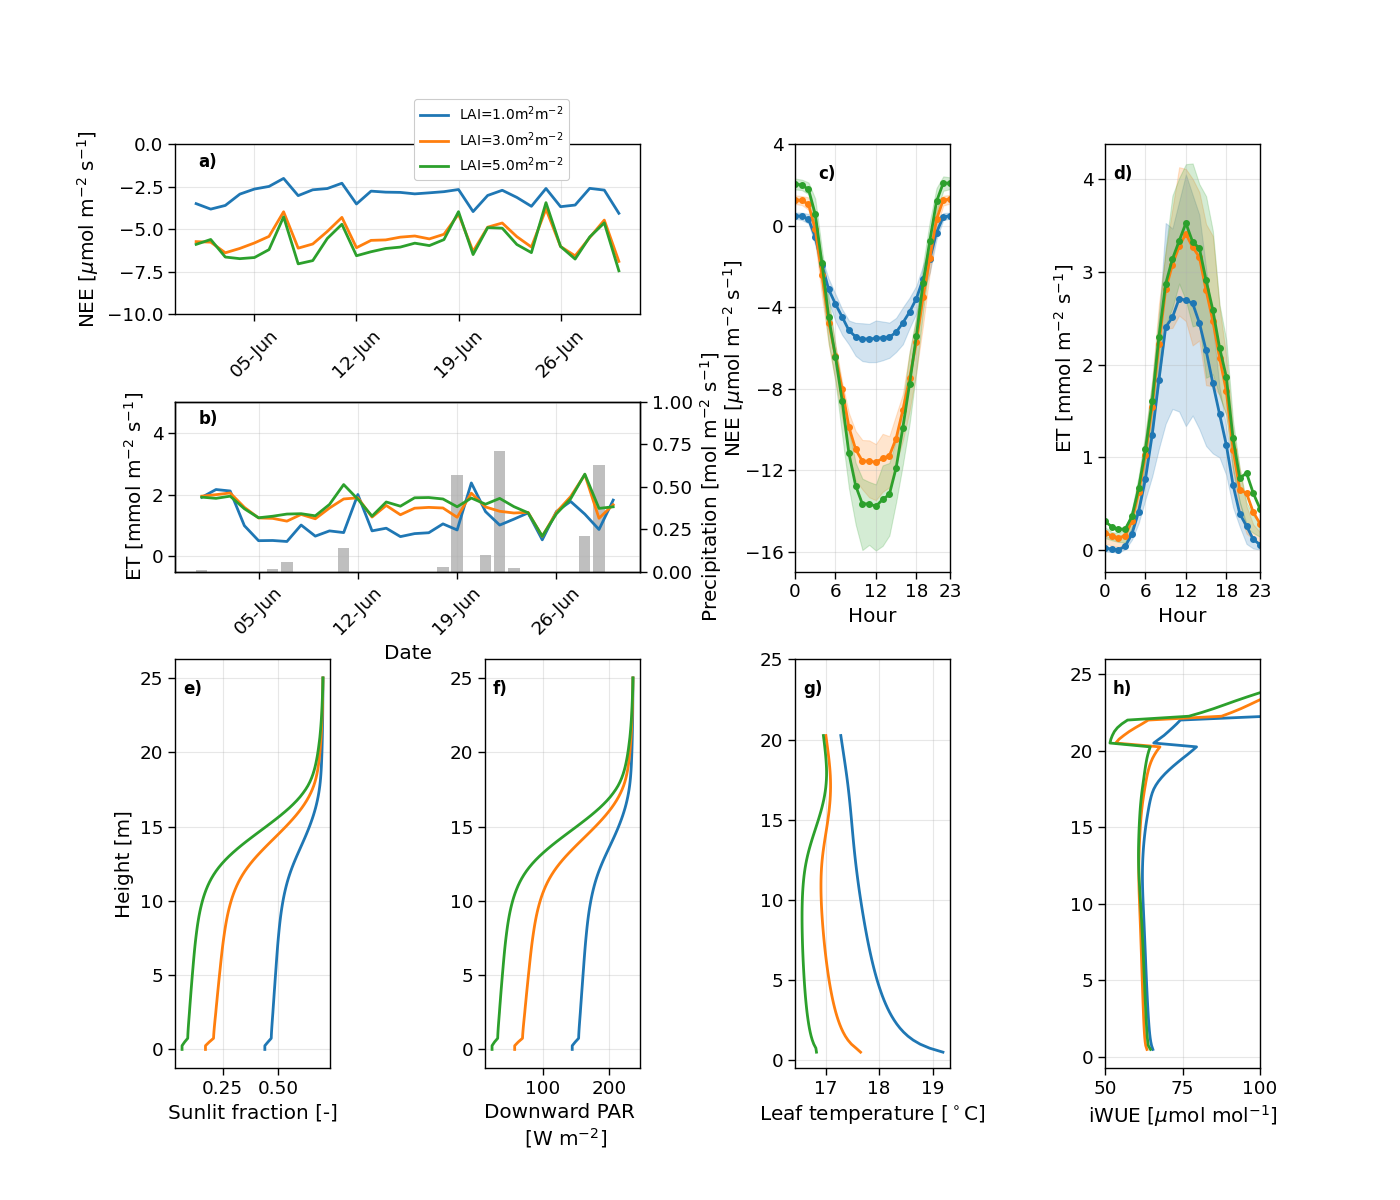

In [6]:
# Create figure with all plots
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 4, figure=fig, height_ratios=[0.5, 0.5, 1.2], 
              hspace=0.35, wspace=1.0)

# Row 0-1: Time series (NEE and ET stacked) on left, diurnal cycles on right (spanning 2 rows)
ax_ts_nee = fig.add_subplot(gs[0, 0:2])   # NEE time series
ax_ts_et = fig.add_subplot(gs[1, 0:2])    # ET time series
ax_dc_nee = fig.add_subplot(gs[0:2, 2])   # NEE diurnal cycle (spans 2 rows)
ax_dc_et = fig.add_subplot(gs[0:2, 3])    # ET diurnal cycle (spans 2 rows)

# Row 2: Vertical profiles (4 plots)
ax_sunlit = fig.add_subplot(gs[2, 0])  # Sunlit fraction
ax_par = fig.add_subplot(gs[2, 1])     # Downwelling PAR
ax_temp = fig.add_subplot(gs[2, 2])    # Leaf temperature
ax_iwue = fig.add_subplot(gs[2, 3])    # iWUE

# legend bbox anchor
bbox_anchor = (0.5, 0.75)

# --- Row 0-1: Time series WITHOUT percentiles ---

# Create secondary y-axis for precipitation
ax_ts_et_prec = ax_ts_et.twinx()
ax_ts_et_prec.bar(prec_daily.date, prec_daily, color='gray', alpha=0.5, width=0.8, zorder=1)
ax_ts_et_prec.set_ylim([0, 1])
ax_ts_et_prec.set_ylabel(r'Precipitation [mol m$^{-2}$ s$^{-1}$]', color='k')
ax_ts_et_prec.tick_params(axis='y', labelcolor='k')

for lai, sim_idx, color in zip(LAI_values, sim_indices, colors_lai):
    # NEE time series - daily mean only
    nee_daily = nee_data[lai].resample(date='D').mean()
    ax_ts_nee.plot(nee_daily.date, nee_daily, color=color, linewidth=2, label=f'LAI={lai}m$^2$m$^{{-2}}$')

    # ET time series - daily mean only
    et_daily = et_data[lai].resample(date='D').mean()
    ax_ts_et.plot(et_daily.date, et_daily, color=color, linewidth=2, label=f'LAI={lai}', zorder=3)
    
    # # Canopy evaporation (interception) with circle marker
    # evap_canopy_daily = evap_canopy_data[lai].resample(date='D').mean()
    # ax_ts_et.plot(evap_canopy_daily.date, evap_canopy_daily, 'o', color=color, markersize=5, alpha=0.7, zorder=4)
    
    # # Forest floor evaporation with 'x' marker
    # evap_ffloor_daily = evap_ffloor_data[lai].resample(date='D').mean()
    # ax_ts_et.plot(evap_ffloor_daily.date, evap_ffloor_daily, 'x', color=color, markersize=5, alpha=0.7, zorder=4)
    
    # # Canopy transpiration with triangle marker
    # transp_daily = transp_data[lai].resample(date='D').mean()
    # ax_ts_et.plot(transp_daily.date, transp_daily, '^', color=color, markersize=5, alpha=0.7, zorder=4)

# Format time series axes with weekly ticks
import matplotlib.dates as mdates
for ax in [ax_ts_nee, ax_ts_et]:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Weekly ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x', rotation=45)

ax_ts_nee.set_ylabel(r'NEE [$\mu$mol m$^{-2}$ s$^{-1}$]')
ax_ts_nee.grid(True, alpha=0.3)

# Add custom legend with ET component markers
handles, labels = ax_ts_nee.get_legend_handles_labels()
# evap_handle = Line2D([0], [0], marker='o', color='gray', linestyle='None', 
#                      markersize=6, label='Interception storage evaporation')
# ffloor_handle = Line2D([0], [0], marker='x', color='gray', linestyle='None', 
#                        markersize=6, label='Forest floor evaporation')
# transp_handle = Line2D([0], [0], marker='^', color='gray', linestyle='None', 
#                        markersize=6, label='Canopy transpiration')
# prec_handle = Line2D([0], [0], marker='s', color='gray', linestyle='None', 
#                      markersize=6, alpha=0.5, label='Precipitation')
# handles.extend([evap_handle, ffloor_handle, transp_handle, prec_handle])
# labels.extend(['Interception storage evaporation', 'Forest floor evaporation', 'Canopy transpiration', 'Precipitation'])
ax_ts_nee.legend(handles=handles, labels=labels, fontsize=10, bbox_to_anchor=bbox_anchor, framealpha=1)

ax_ts_nee.text(0.05, 0.95, 'a)', transform=ax_ts_nee.transAxes, fontsize=12, 
               fontweight='bold', va='top', ha='left')
ax_ts_nee.set_ylim([-10, 0])

ax_ts_et.set_ylabel(r'ET [mmol m$^{-2}$ s$^{-1}$]')
ax_ts_et.set_xlabel('Date')
ax_ts_et.grid(True, alpha=0.3)
ax_ts_et.text(0.05, 0.95, 'b)', transform=ax_ts_et.transAxes, fontsize=12, 
              fontweight='bold', va='top', ha='left')
ax_ts_et.set_ylim([-0.5, 5])
ax_ts_et.set_zorder(ax_ts_et_prec.get_zorder() + 1)
ax_ts_et.patch.set_visible(False)

# --- Diurnal cycles ---
for lai, sim_idx, color in zip(LAI_values, sim_indices, colors_lai):
    # Convert to DataFrame for diurnal_cycle function
    nee_df = nee_data[lai].to_dataframe(name='NEE')
    et_df = et_data[lai].to_dataframe(name='ET')
    evap_df = evap_canopy_data[lai].to_dataframe(name='evap')
    
    # Calculate diurnal cycles
    dc_nee = diurnal_cycle(nee_df[['NEE']], ap='hour')['NEE']
    dc_et = diurnal_cycle(et_df[['ET']], ap='hour')['ET']
    dc_evap = diurnal_cycle(evap_df[['evap']], ap='hour')['evap']
    
    # Plot NEE diurnal cycle
    ax_dc_nee.plot(dc_nee['hour'], dc_nee['mean'], 'o-', color=color, 
                   label=f'LAI={lai}', linewidth=2, markersize=4)
    ax_dc_nee.fill_between(dc_nee['hour'], dc_nee['25th'], dc_nee['75th'], 
                           color=color, alpha=0.2)
    
    # Plot ET diurnal cycle
    ax_dc_et.plot(dc_et['hour'], dc_et['mean'], 'o-', color=color, 
                  label=f'LAI={lai}', linewidth=2, markersize=4)
    ax_dc_et.fill_between(dc_et['hour'], dc_et['25th'], dc_et['75th'], 
                          color=color, alpha=0.2)

# Format diurnal cycle axes
ax_dc_nee.set_xlabel('Hour')
ax_dc_nee.set_ylabel(r'NEE [$\mu$mol m$^{-2}$ s$^{-1}$]')
ax_dc_nee.set_xlim(0, 23)
ax_dc_nee.set_xticks([0, 6, 12, 18, 23])
ax_dc_nee.grid(True, alpha=0.3)
ax_dc_nee.text(0.15, 0.95, 'c)', transform=ax_dc_nee.transAxes, fontsize=12, 
               fontweight='bold', va='top', ha='left')
ax_dc_nee.set_ylim([-17, 4])
ax_dc_nee.set_yticks([-16, -12, -8, -4, 0 , 4])
ax_dc_nee.yaxis.labelpad=-2

ax_dc_et.set_xlabel('Hour')
ax_dc_et.set_ylabel(r'ET [mmol m$^{-2}$ s$^{-1}$]')
ax_dc_et.set_xlim(0, 23)
ax_dc_et.set_xticks([0, 6, 12, 18, 23])
ax_dc_et.grid(True, alpha=0.3)
ax_dc_et.text(0.05, 0.95, 'd)', transform=ax_dc_et.transAxes, fontsize=12, 
              fontweight='bold', va='top', ha='left')

# --- Row 2: Vertical profiles ---

# 1. Sunlit fraction
for lai, color in zip(LAI_values, colors_lai):
    ax_sunlit.plot(profile_data[lai]['sunlit_frac'], canopy_z, 
                   color=color, linewidth=2, label=f'LAI={lai}')

ax_sunlit.set_xlabel('Sunlit fraction [-]')
ax_sunlit.set_ylabel('Height [m]')
ax_sunlit.set_yticks([0, 5, 10, 15, 20, 25])
ax_sunlit.grid(True, alpha=0.3)
ax_sunlit.text(0.05, 0.95, 'e)', transform=ax_sunlit.transAxes, fontsize=12, 
               fontweight='bold', va='top', ha='left')

# 2. PAR down
for lai, color in zip(LAI_values, colors_lai):
    ax_par.plot(profile_data[lai]['par_down'], canopy_z, 
                color=color, linewidth=2, label=f'LAI={lai}')

ax_par.set_xlabel('Downward PAR \n [W m$^{-2}$]')
ax_par.set_yticks([0, 5, 10, 15, 20, 25])
ax_par.grid(True, alpha=0.3)
ax_par.text(0.05, 0.95, 'f)', transform=ax_par.transAxes, fontsize=12, 
            fontweight='bold', va='top', ha='left')

# 3. Leaf temperature
for lai, color in zip(LAI_values, colors_lai):
    ax_temp.plot(profile_data[lai]['temp'], canopy_z, 
                color=color, linewidth=2, label=f'LAI={lai}')

ax_temp.set_xlabel(r'Leaf temperature [$^\circ$C]')
ax_temp.set_yticks([0, 5, 10, 15, 20, 25])
ax_temp.grid(True, alpha=0.3)
ax_temp.text(0.05, 0.95, 'g)', transform=ax_temp.transAxes, fontsize=12, 
             fontweight='bold', va='top', ha='left')

# 4. iWUE
for lai, color in zip(LAI_values, colors_lai):
    iwue = profile_data[lai]['iwue']
    ax_iwue.plot(iwue, canopy_z, color=color, linewidth=2, label=f'LAI={lai}')

ax_iwue.set_xlabel(r'iWUE [$\mu$mol mol$^{-1}$]')
ax_iwue.set_yticks([0, 5, 10, 15, 20, 25])
ax_iwue.set_xlim([50, 100])
ax_iwue.grid(True, alpha=0.3)
ax_iwue.text(0.05, 0.95, 'h)', transform=ax_iwue.transAxes, fontsize=12, 
             fontweight='bold', va='top', ha='left')

plt.tight_layout()